In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [8]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [9]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [10]:
x = torch.randn((1,10))

In [11]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[1.0424e-06, 3.4132e-04, 7.8166e-05, 3.1167e-06, 4.8731e-06, 4.2115e-07,
          3.3546e-04, 9.9921e-01, 8.4344e-08, 2.6827e-05]]),
 tensor([[0.0318, 0.1014, 0.0755, 0.0396, 0.0433, 0.0266, 0.1010, 0.5004, 0.0193,
          0.0610]]),
 tensor([[0.0648, 0.1157, 0.0998, 0.0723, 0.0756, 0.0592, 0.1155, 0.2570, 0.0504,
          0.0897]]))

In [12]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [13]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [14]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [15]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

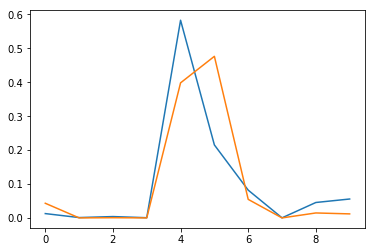

In [16]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [17]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): self.alpha[0] = self.true_mu
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.wrapper.x = self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor: pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:  
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
#         print(h,ikk)
        return ikk
        
    def on_forwards_end(self) -> None:
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

In [18]:
class PaperInferno(AbsInferno):
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def on_train_begin(self) -> None:
        super().on_train_begin()
#         if self.float_l:
#             with torch.no_grad(): self.alpha[-1] = 1
        
    def aug_data(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        i = 1
        if self.float_r:
            x[:,0] += self.alpha[i]
            i += 1
        if self.float_l:
            x[:,2] *= (self.alpha[i]+self.l_init)/self.l_init
        return x

In [19]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [20]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=0, float_l=0, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie0.h5'),EarlyStopping(10)])

1: Train=542.0647637939453 Valid=439.3646649169922
2: Train=383.5322750854492 Valid=356.0632116699219
3: Train=341.5341128540039 Valid=341.32151672363284
4: Train=331.19568023681643 Valid=333.9284991455078
5: Train=324.1363275146484 Valid=327.2334002685547
6: Train=317.2622982788086 Valid=320.2613165283203
7: Train=311.17376190185547 Valid=315.3764996337891
8: Train=307.1248323059082 Valid=311.77720458984373
9: Train=303.8957130432129 Valid=308.64957153320313
10: Train=301.21911560058595 Valid=305.83807678222655
11: Train=298.757412109375 Valid=303.6198254394531
12: Train=296.2546145629883 Valid=300.98810546875
13: Train=294.2177409362793 Valid=298.98508911132814
14: Train=292.268973236084 Valid=296.92695068359376
15: Train=290.6751237487793 Valid=294.8057751464844
16: Train=289.04144149780274 Valid=293.3690551757812
17: Train=287.3317109680176 Valid=291.48072998046877
18: Train=286.31773391723635 Valid=290.0255535888672
19: Train=284.58439880371094 Valid=288.70955139160156
20: Train=2

156: Train=253.47545684814452 Valid=257.77310852050783
157: Train=253.28331436157225 Valid=257.86146270751954
158: Train=253.47535415649415 Valid=257.83041015625
159: Train=253.29473159790038 Valid=257.7385739135742
160: Train=253.29867614746092 Valid=257.73440643310545
161: Train=253.3936340332031 Valid=257.7169400024414
162: Train=253.39005401611328 Valid=257.54946990966795
163: Train=253.08616271972656 Valid=257.62501953125
164: Train=252.9543000793457 Valid=257.63557189941406
165: Train=253.26763305664062 Valid=257.43448364257813
166: Train=253.1672334289551 Valid=257.44599700927733
167: Train=253.21470657348632 Valid=257.29890228271483
168: Train=252.84039993286132 Valid=257.5050115966797
169: Train=252.86958602905273 Valid=257.27382110595704
170: Train=252.98357788085937 Valid=257.3477816772461
171: Train=252.7447183227539 Valid=257.2654397583008
172: Train=252.91009368896485 Valid=257.2911862182617
173: Train=252.78836822509766 Valid=257.16425170898435
174: Train=252.52192108154

In [21]:
model.save('weights/Inferno_Test_exact_bm0.h5')

model.load('weights/Inferno_Test_exact_bm1.h5')

# Results

In [22]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [23]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [24]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,1,1.0
1,7,1.0
2,7,1.0
3,1,1.0
4,3,1.0


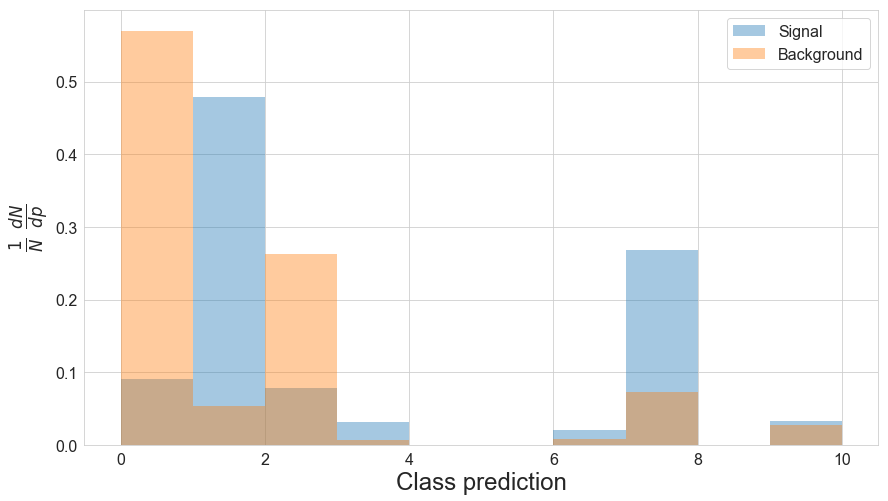

In [25]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [26]:
bin_preds(df)

In [27]:
df.head()

,pred,gen_target,pred_bin
0,1,1.0,1
1,7,1.0,7
2,7,1.0,7
3,1,1.0,1
4,3,1.0,3


In [28]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [29]:
f_s.sum(), f_b.sum()

(tensor(1.0000), tensor(1.))

In [30]:
f_s, f_b

(tensor([5.6921e-01, 7.8780e-02, 3.1612e-02, 2.0000e-13, 2.0000e-13, 1.9892e-02,
         2.6840e-01, 2.0000e-13, 3.2106e-02, 2.0000e-13]),
 tensor([6.2397e-01, 2.6259e-01, 6.6740e-03, 2.0000e-13, 2.0000e-13, 7.5400e-03,
         7.2408e-02, 2.0000e-13, 2.6814e-02, 2.0000e-13]))

In [31]:
asimov = (50*f_s)+(1000*f_b)

In [32]:
asimov, asimov.sum()

(tensor([6.5243e+02, 2.6653e+02, 8.2546e+00, 2.1000e-10, 2.1000e-10, 8.5346e+00,
         8.5828e+01, 2.1000e-10, 2.8419e+01, 2.1000e-10]), tensor(1050.))

In [33]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([18.33706284, 18.28779793, 18.23953438, 18.19402885, 18.14921951,
       18.10665894, 18.06641388, 18.02721024, 17.99045563, 17.95449066,
       17.92077065, 17.88947678, 17.85851479, 17.83027458, 17.80334854,
       17.77831841, 17.75502586, 17.73302078, 17.71322632, 17.69452667,
       17.67749786, 17.66225815, 17.64925003, 17.63685226, 17.62688828,
       17.61776543, 17.61090851, 17.60542679, 17.60131264, 17.59890747,
       17.59849548, 17.59911346, 17.60130692, 17.60507965, 17.61078644,
       17.61761856, 17.62574577, 17.63586044, 17.64766693, 17.6605835 ,
       17.67498589, 17.69143295, 17.70900917, 17.72739792, 17.74789047,
       17.77006912, 17.79366302, 17.81843567, 17.84470367, 17.87197113,
       17.90153503, 17.93214035, 17.96399307, 17.99776459, 18.03221512,
       18.06830215, 18.1058712 , 18.14523315, 18.18532181, 18.22727203,
       18.27015114])

In [34]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [35]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

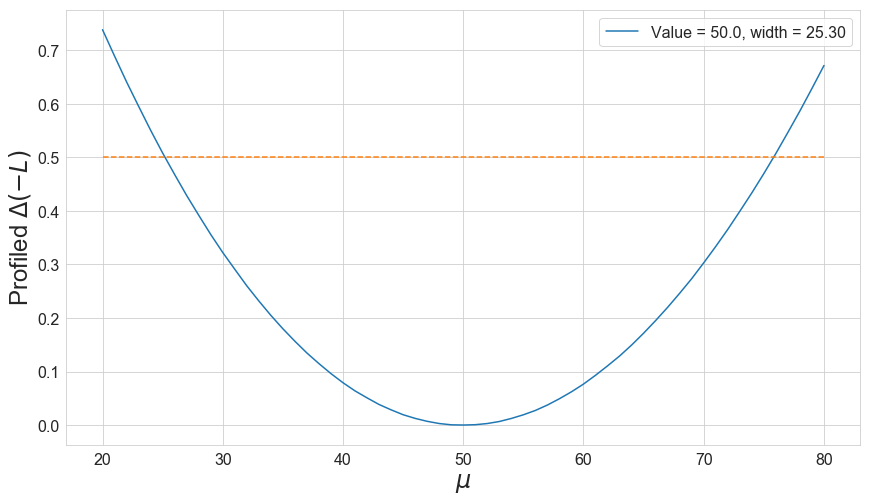

In [36]:
plot_likelihood(y-y.min())

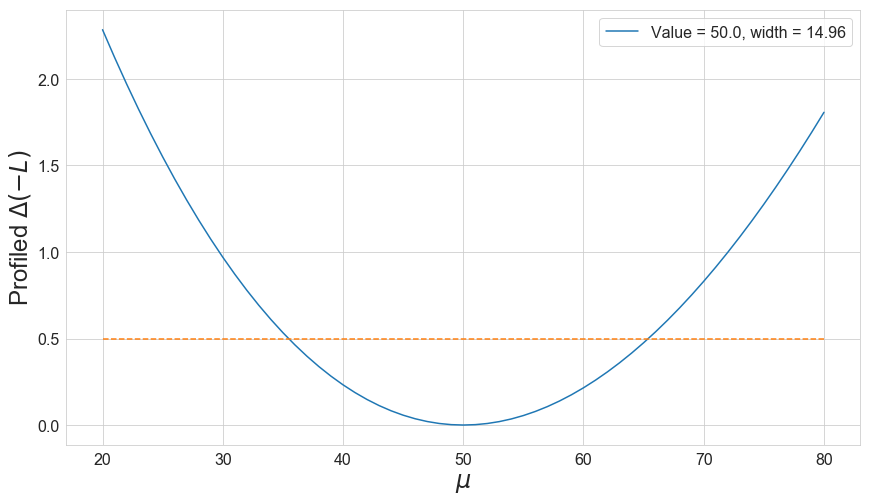

In [37]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [38]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [39]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [40]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,1,1.0,1,1,1,1,1,1,1,1,1,1,1
1,7,1.0,7,7,7,7,7,7,7,7,7,7,7
2,7,1.0,7,7,7,7,7,7,7,7,7,7,7
3,1,1.0,1,1,1,1,1,1,1,1,1,1,1
4,3,1.0,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999996,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999997,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999998,2,0.0,2,2,2,2,2,2,2,2,2,2,2


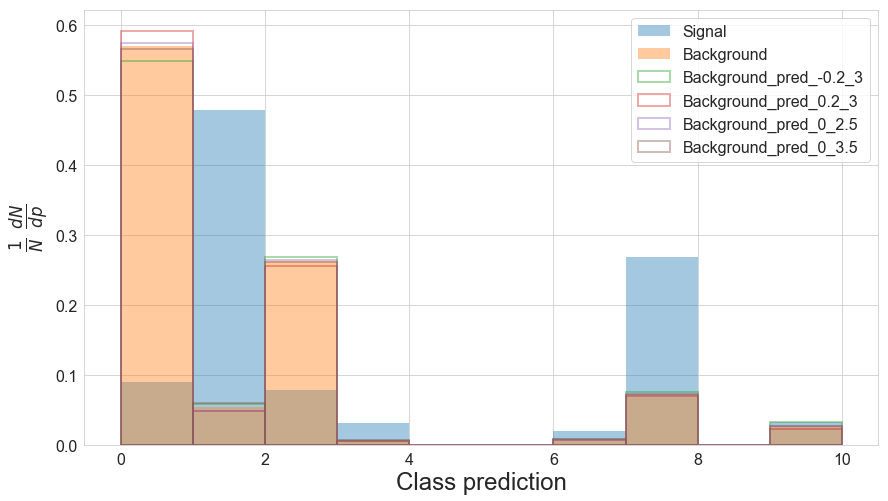

In [41]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([6.0555e-01, 2.7031e-01, 8.3500e-03, 2.0000e-13, 2.0000e-13, 7.8960e-03,
        7.5556e-02, 2.0000e-13, 3.2332e-02, 2.0000e-13])
tensor([6.0704e-01, 2.6890e-01, 7.5220e-03, 2.0000e-13, 2.0000e-13, 8.2400e-03,
        7.6130e-02, 2.0000e-13, 3.2168e-02, 2.0000e-13])
tensor([6.0880e-01, 2.6741e-01, 6.9560e-03, 2.0000e-13, 2.0000e-13, 8.4880e-03,
        7.6476e-02, 2.0000e-13, 3.1868e-02, 2.0000e-13])
tensor([6.2248e-01, 2.6401e-01, 7.5020e-03, 2.0000e-13, 2.0000e-13, 7.1960e-03,
        7.1834e-02, 2.0000e-13, 2.6978e-02, 2.0000e-13])
tensor([6.2397e-01, 2.6259e-01, 6.6740e-03, 2.0000e-13, 2.0000e-13, 7.5400e-03,
        7.2408e-02, 2.0000e-13, 2.6814e-02, 2.0000e-13])
tensor([6.2573e-01, 2.6110e-01, 6.1080e-03, 2.0000e-13, 2.0000e-13, 7.7880e-03,
        7.2754e-02, 2.0000e-13, 2.6514e-02, 2.0000e-13])
tensor([6.3890e-01, 2.5724e-01, 6.6720e-03, 2.0000e-13, 2.0000e-13, 6.4320e-03,
        6.8486e-02, 2.0000e-13, 2.2272e-02, 2.0000e-13])
tensor([6.4039e-01, 2.5582e-01, 5.8440e-0

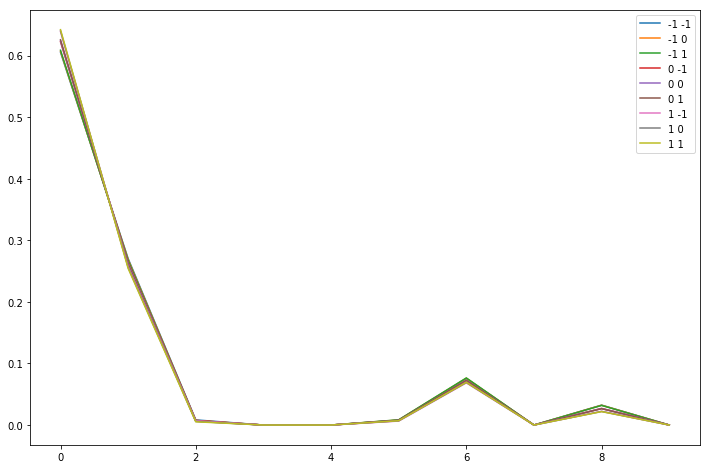

In [42]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [43]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [44]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [45]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [46]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [47]:
nll = to_np(nll)

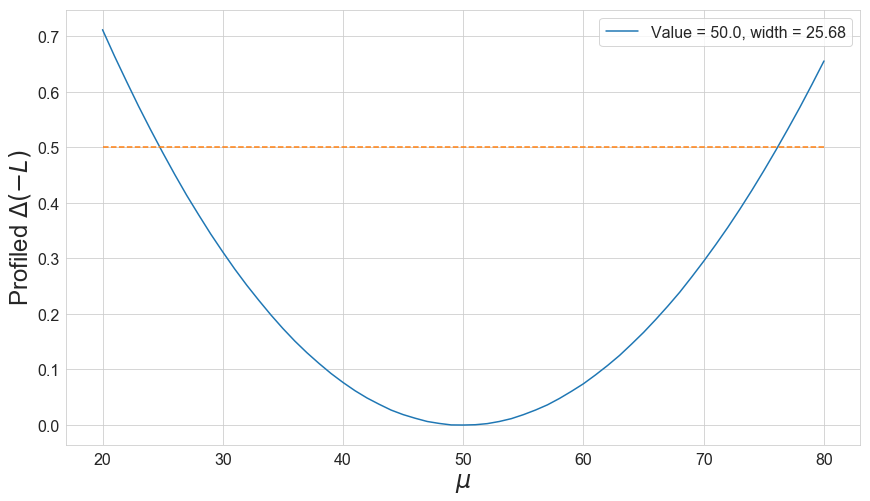

In [48]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [49]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [50]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [51]:
nll = to_np(nll)

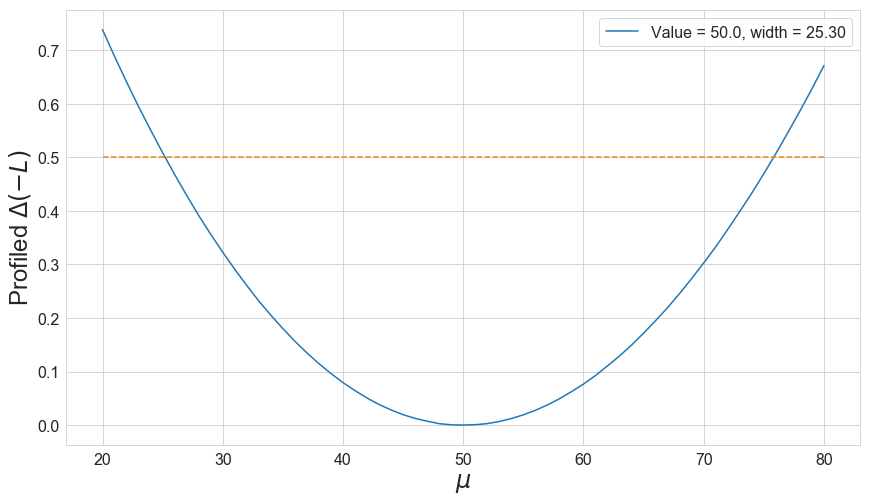

In [52]:
plot_likelihood(nll-nll.min())

## BM 2

In [53]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [54]:
nll = to_np(nll)

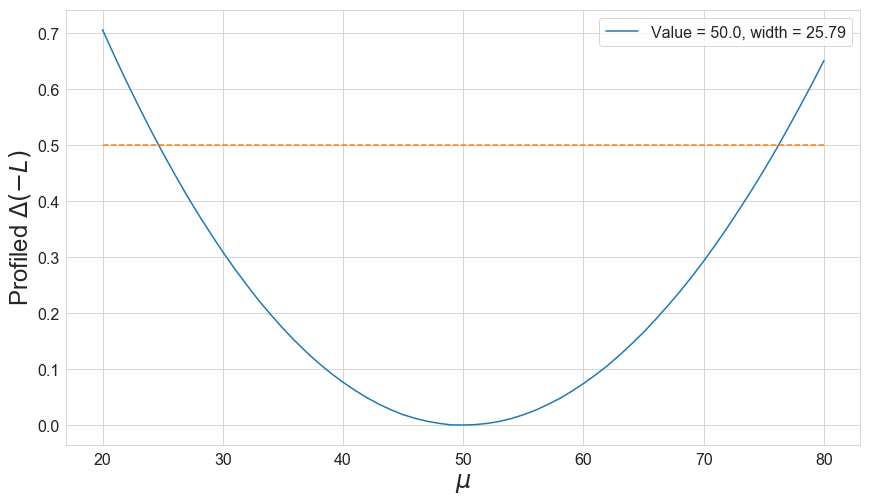

In [55]:
plot_likelihood(nll-nll.min())